In [1]:
%matplotlib inline

import numpy as np
from neo.io import NeoHdf5IO
import matplotlib.pyplot as plt
from stfio.stfio_plot import plot_scalebars
from scipy.signal import butter,filtfilt,lfilter

## Input Resistance

In [2]:
def load_data(path):
    '''Load data from .h5 file'''
    r = NeoHdf5IO(path)
    blks = r.read_all_blocks()
    r.close
    data = [blk.segments[0].analogsignalarrays[0] for blk in blks]
    return data

In [3]:
data = load_data('./sup_data/Rin.h5')

In [4]:
len(data)

6

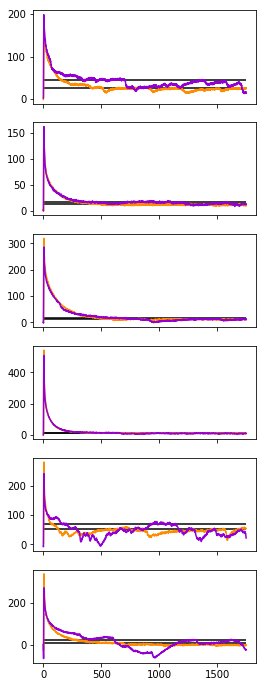

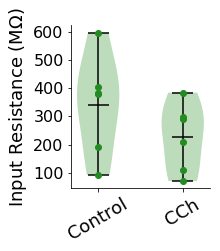

In [15]:

fig,axs = plt.subplots(nrows=len(data),ncols=1, sharex=True,figsize=(4,12))

Rin_ctr = []
Rin_cch = []
thresh = 90

for traces,ax in zip(data,axs):
    x1 = np.mean(traces[:,2:12],axis=1)
    x2 = np.mean(traces[:,-10:],axis=1)
    ax.plot(x1,color='darkorange')
    ax.plot(x2,color='darkviolet')
    ax.hlines(np.percentile(x1[500:],thresh),0,len(x1))
    ax.hlines(np.percentile(x2[500:],thresh),0,len(x2))
    Rin_ctr.append(5000/np.percentile(x1[500:],thresh))
    Rin_cch.append(5000/np.percentile(x2[500:],thresh))

plt.show()
    
fig = plt.figure(figsize=(2.5,3))
parts = plt.violinplot([Rin_ctr,Rin_cch],showmeans=True);
plt.plot(np.ones_like(Rin_ctr),Rin_ctr,'o',color='forestgreen')
plt.plot(np.ones_like(Rin_cch)*2,Rin_cch,'o',color='forestgreen')

plt.xticks([1,2],['Control','CCh'],rotation=30,fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel(r'Input Resistance (M$\mathrm{\Omega}$)',fontsize=18)

for pc in parts['bodies']:
    pc.set_facecolor('forestgreen')

for key in parts.keys():
    if 'c' in key:
        l = parts[key]
        l.set_color('k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.savefig('./reworked_figs/Rin.svg')

In [13]:
np.mean([Rin_ctr,Rin_cch],axis=1),np.std([Rin_ctr,Rin_cch],ddof=1,axis=1)

(array([ 316.02274564,  206.55398741]), array([ 149.02253643,  115.29823469]))

## Spontaneous EPSC and IPSC frequency and holding current

In [16]:
def load_irr_data(path,segnum):
    '''Load data from .h5 file'''
    r = NeoHdf5IO(path)
    blk = r.read_block()
    r.close()
    seg = blk.segments
    data = seg[segnum].analogsignalarrays[0]
    return data

def butter_highpass(highcut,fs, order=2):
    '''Create butterworth filter'''
    nyq = 0.5*fs
    high = highcut/nyq
    b,a = butter(order, high, btype='highpass')
    return b,a
    
def butter_highpass_filter(data,highcut,fs,order=2):
    '''Filter data using butterworth filter to remove DC and other slow fluctuations'''
    b,a = butter_highpass(highcut,fs,order=order)
    fdata = filtfilt(b,a,data)
    return fdata

def EPSC_kernel(taur,taud,sample_rate):
    l = taud*5*sample_rate
    x = np.arange(0,l)/sample_rate
    k = np.exp(-x/taud) - np.exp(-x/taur)
    k = -k/np.sum(k)
    return k

def IPSC_kernel(taur,taud,sample_rate):
    l = taud*5*sample_rate
    x = np.arange(0,l)/sample_rate
    k = np.exp(-x/taud) - np.exp(-x/taur)
    k = k/np.sum(k)
    return k

def find_spscs(y,thresh):
    y1 = np.diff(y)[:-1]
    y2 = np.diff(y)[1:]
    threshcross = [t for (t,z1,z2) in zip(range(len(y1)),y1,y2) if ((z1<thresh) and (z2>thresh))]
    return threshcross

In [36]:
filenames = ['160809_epsc_cch_1.h5','160902_epsc_cch_1.h5','160905_epsc_cch_1.h5',
             '160912_epsc_cch_1.h5','160914_epsc_cch_2.h5','160923_epsc_cch_1.h5']

spsc_freq = []
i_hold = []

for filename in filenames:
    data = load_irr_data('./.gitignore/'+filename,0)
    fdata = np.array([])
    hc = []
    for x in data.T:
        x = np.array(x)
        hc.append(np.percentile(x,99.9))
        fx = butter_highpass_filter(x,highcut=0.1,fs=10000,order=3)
        fdata = np.append(fdata,fx)
    
    i_hold.append(hc)

    fdata = np.reshape(fdata,np.shape(data.T))
    k = EPSC_kernel(taur=0.0005,taud=0.005,sample_rate=10000)
    y_ctr = lfilter(k,[1],fdata[0])
    y_cch = lfilter(k,[1],fdata[1])

    s_ctr = find_spscs(y_ctr,0.25);
    s_cch = find_spscs(y_cch,0.25);
    
    spsc_freq.append([len(s_ctr)/550.,len(s_cch)/550.])
    
i_hold = np.array(i_hold)
spsc_freq = np.array(spsc_freq)

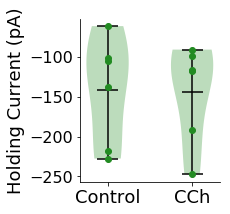

In [44]:
fig = plt.figure(figsize=(2.5,3))
    
hc_ctr,hc_cch = i_hold.T
parts = plt.violinplot(i_hold,showmeans=True);
plt.plot(np.ones_like(hc_ctr),hc_ctr,'o',color='forestgreen')
plt.plot(np.ones_like(hc_cch)*2,hc_cch,'o',color='forestgreen')

plt.xticks([1,2],['Control','CCh'],fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel(r'Holding Current (pA)',fontsize=18)

for pc in parts['bodies']:
    pc.set_facecolor('forestgreen')

for key in parts.keys():
    if 'c' in key:
        l = parts[key]
        l.set_color('k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.savefig('./reworked_figs/i_hold.svg')

In [41]:
i_hold.mean(axis=0),i_hold.std(axis=0,ddof=1)

(array([-141.48966471, -143.64624023]), array([ 67.45099382,  62.23435872]))

In [220]:
with open('./sup_data/sepsc_freq.csv','w') as myfile:
    np.savetxt(myfile,spsc_freq,delimiter=',')

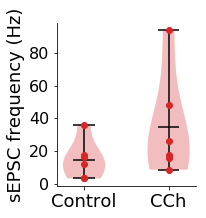

In [219]:
fig = plt.figure(figsize=(2.5,3))
    
s_ctr,s_cch = spsc_freq.T
parts = plt.violinplot(spsc_freq,showmeans=True);
plt.plot(np.ones_like(s_ctr),s_ctr,'o',color='C3')
plt.plot(np.ones_like(s_cch)*2,s_cch,'o',color='C3')

plt.xticks([1,2],['Control','CCh'],fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel(r'sEPSC frequency (Hz)',fontsize=18)

for pc in parts['bodies']:
    pc.set_facecolor('C3')

for key in parts.keys():
    if 'c' in key:
        l = parts[key]
        l.set_color('k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.savefig('./reworked_figs/sepsc_freq.svg')

In [252]:
filenames = ['161026_ipsc_cch_1.h5','161027_ipsc_cch_1.h5','161028_ipsc_cch_1.h5',
             '161030_ipsc_cch_1.h5','161030_ipsc_cch_2.h5']

spsc_freq = []

for filename in filenames:
    data = load_irr_data('./.gitignore/'+filename,0)
    fdata = np.array([])
    for x in data.T:
        x = np.array(x)
        fx = butter_highpass_filter(x,highcut=0.1,fs=10000,order=3)
        fdata = np.append(fdata,fx)

    fdata = np.reshape(fdata,np.shape(data.T))
    k = IPSC_kernel(taur=0.0005,taud=0.005,sample_rate=10000)
    y_ctr = lfilter(k,[1],fdata[0])
    y_cch = lfilter(k,[1],fdata[1])

    s_ctr = find_spscs(y_ctr,0.25);
    s_cch = find_spscs(y_cch,0.25);
    
    spsc_freq.append([len(s_ctr)/550.,len(s_cch)/550.])
    
spsc_freq = np.array(spsc_freq)

In [255]:
with open('./sup_data/sipsc_freq.csv','w') as myfile:
    np.savetxt(myfile,spsc_freq,delimiter=',')

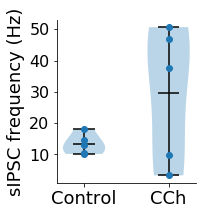

In [254]:
fig = plt.figure(figsize=(2.5,3))
    
s_ctr,s_cch = spsc_freq.T
parts = plt.violinplot(spsc_freq,showmeans=True);
plt.plot(np.ones_like(s_ctr),s_ctr,'o',color='C0')
plt.plot(np.ones_like(s_cch)*2,s_cch,'o',color='C0')

plt.xticks([1,2],['Control','CCh'],fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel(r'sIPSC frequency (Hz)',fontsize=18)

for pc in parts['bodies']:
    pc.set_facecolor('C0')

for key in parts.keys():
    if 'c' in key:
        l = parts[key]
        l.set_color('k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.savefig('./reworked_figs/sipsc_freq.svg')